# Introduction to Reservoir Computing

## What is a reservoir?

A reservoir is a high-dimensional dynamical system with the <b>fading memory</b> property. This property states that:

1) <i>The reservoir must have recurrent feedback such that the state of the network at any time reflects its past input history. In other words, the system must have a dynamical memory.</i>

2) <i>This memory must fade over time, such that the reservoir eventually forgets any initial conditions.</i>

This essential property allows input data to be projected into a high-dimensional function space containing contextual information about recent past inputs. The information within the reservoir can then be fed into a linear classifier, which uses linear combinations of these functions to perform the desired classification or prediction task.

## How are reservoirs useful?

Time-series prediction and classification are notoriously difficult, especially in real time. For example, let's say you want to track the motion of an object using a feed-forward neural network. In this case, not only would you need a set of N neurons to identify the object in a still image, you would need a separate set of N neurons for each additional time-frame relevant to the motion of the object. This could be tens or hundreds of frames! Essentially, what this is doing is representing time extrinsically, as an extra spatial dimension, which turns out to be very inefficient.

A more clever method is to use a recurrent neural network capable of capturing the true dynamics of the object being tracked. In this case, time is represented intrinsically rather than extrinsically. While they are extremely powerful, however, recurrent neural networks are notoriously difficult to train. The standard technique of backpropagation through time (BTT) often either fails completely or leads to excruciatingly slow learning.

This is where reservoir computing comes in. Instead of attempting to learn the weights of the recurrent neural network, we instead create a random network with macroscopic dynamics (i.e. time constants, length scales) similar to the system we're trying to model or predict. Then we train a feed-forward neural network to interpret the current state of the reservoir, which naturally contains information about its past inputs.

# The Reservoir Computing Architecture

<img src="reservoir.png">

## Input and Reservoir

In any reservoir computing architecture, we are primarily concerned with three variables. The first is the input vector <b>X</b>(t). This is the time-series of interest, which may have one or many dimensions. The second is the current state of the reservoir, <b>Z</b>(t). The nodes in the reservoir are typically modeled as leaky integrators. At any given time, the state of the reservoir <b>Z</b>(t) is given by:

$$\textbf{Z}(t) = \sigma(\textbf{W}^{in}\textbf{X}(t) + \textbf{W}^{res}\textbf{Z}(t-1))   $$

The last variable of interest is the readout, <b>Y</b>(t). The readout is a small subset of the reservoir internal state nodes, and is used as input to the linear classifier or feed-forward network.

## Readout and Classifier

As inputs are presented to the reservoir, the readout <b>Y</b>(t) is used as input for a linear classifier, which has the advantage of quick and easy training. The best classifier for reservoir computing is generally considered to be ridge regression, however feed-forward neural networks may also be used.

# Spoken Digit Classification

In this section, we'll use a python module called <a href="http://organic.elis.ugent.be/organic/engine">Oger (OrGanic Environment for Reservoir computing)</a> to build, train, and test a reservoir computing model against a set of speech data. First, we need to install the necessary dependencies. This can be accomplished easily using python's pip installer. Simply type the following in your command prompt:

<code>pip install mdp</code>

After a few seconds, pip should have successfully installed <a href="http://mdp-toolkit.sourceforge.net/">MDP (Modular toolkit for Data Processing)</a>. Next, we need to install Oger:

<code>pip install oger</code>

Note that you must have installed Anaconda or a similar scientific Python distribution before using pip. These distributions also come with other useful libraries such as numpy, scipy, and matplotlib.

Next, we need to do some imports.

In [25]:
#Import stuff
import numpy as np
import Oger as oger
import matplotlib.pyplot as plt
import scipy as sp
import mdp

%matplotlib inline

Now we will load the data. In this example, we'll be using spoken digit waveforms that have been preprocessed using the Lyon Passive Ear model. The goal will be to associate the audio waveforms with the digits they represent. The variable "inputs" represents the features for each input vector <b>X</b>(t). The variable "outputs" corresponds to the class of the digit (i.e. 0 through 9). It is a ten-dimensional vector, with +1 for the current class, and -1 for all others.

In [26]:
#Load and visualize the data
[inputs, outputs] = oger.datasets.analog_speech(indir="Lyon_decimation_128")

Found 500 speech_files in directory Lyon_decimation_128. Loading...


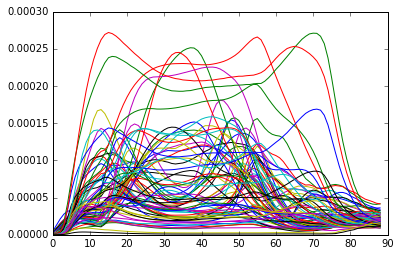

[-1. -1. -1. -1. -1. -1. -1. -1. -1.  1.]


In [27]:
plt.plot(range(len(inputs[-1][:])),inputs[-1][:])
plt.show()
print outputs[-1][0]

Here is where we build the reservoir computing model. We first specify the number of input dimensions, in this case 77. Next, we create a reservoir with 100 nodes. We define the readout to be a ridge regression model, which is then filtered using mean across time. Notice that the dimensionality of the ridge regression model and the mean across time are automatically determined from the dimensionality of their inputs. Finally, the Flow function is used to link everything together.

In [28]:
#Define the architecture for the network
input_dim = inputs[0].shape[1]
reservoir = oger.nodes.LeakyReservoirNode(input_dim=input_dim, output_dim=100, input_scaling=1, leak_rate=0.1)
readout = oger.nodes.RidgeRegressionNode(0.001)
mnnode = oger.nodes.MeanAcrossTimeNode()
flow = mdp.Flow([reservoir, readout, mnnode])

Next, we'll split our data into two subgroups for cross-validation and train the model on the training data.

In [29]:
#Split data for cross-validation and train
train_frac = 0.8
n_samples = len(inputs)
n_train_samples = int(round(n_samples * train_frac))
n_test_samples = int(round(n_samples * (1 - train_frac)))
flow.train([None, \
                zip(inputs[0:n_train_samples - 1], \
                    outputs[0:n_train_samples - 1]), \
                [None]])

Now let's test our model on the test data and check out our error.

In [30]:
#Test model on test data
ytest = []
for xtest in inputs[n_train_samples:]:
    ytest.append(flow(xtest))
    
ymean = sp.array([sp.argmax(sample) for sample in outputs[n_train_samples:]])
ytestmean = sp.array([sp.argmax(sample) for sample in ytest])

confusion_matrix = oger.utils.ConfusionMatrix.from_data(10, ytestmean, ymean)
print "Error rate: %.4f" % confusion_matrix.error_rate

Error rate: 0.1000


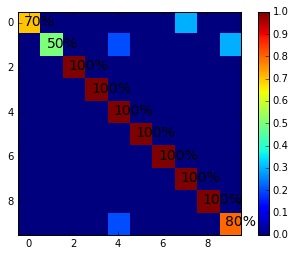

In [31]:
#Visualize error
oger.utils.plot_conf(confusion_matrix.balance())